In [1]:
import numpy as np
from pathlib import Path
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

def find_neighbors(G, node):
    successors = set(G.successors(node))
    predecessors = set(G.predecessors(node))
    neighbors = successors | predecessors
    return len(neighbors)

def read_net_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    nodes = {}
    n_states = 0
    create = True
    
    for line in lines:
        if line.strip() and not line.startswith('*'):  # Ignora le righe vuote e i commenti
            parts = line.strip().split()
            if len(parts) == 5:
                nodes[int(parts[0])-1] = [parts[1].replace('"', ''), float(parts[2]), float(parts[3])]
                n_states += 1
            elif len(parts) == 3:
                if create:
                    matrix = [[0 for _ in range(n_states)] for _ in range(n_states)]
                    create = False
                matrix[int(parts[0])-1][int(parts[1])-1] = float(parts[2])

    return nodes, matrix

In [2]:
dataset_folder = Path.cwd().joinpath("datasets")
data2005 = dataset_folder.joinpath("2005.net")

nodes, m2005 = read_net_file(data2005)

In [3]:
G2005 = nx.DiGraph()

for r in range(len(m2005)):
  for c in range(len(m2005[r])):
    if m2005[r][c]>0:
      G2005.add_edge(nodes[r][0], nodes[c][0], price=m2005[r][c])

print(G2005)

DiGraph with 161 nodes and 17201 edges


In [4]:
Tot2005 = {'Imp':[sum(i) for i in m2005], 'Exp':[sum(m2005[j][i] for j in range(len(m2005))) for i in range(len(m2005))], 'ImpPartners':[sum(1 for e in i if e > 0) for i in m2005], 'ExpPartners':[sum([1 for j in range(len(m2005)) if m2005[j][i] > 0]) for i in range(len(m2005))]}

threshold = 1.0

G2005lite = nx.DiGraph()

for r in range(len(m2005)):
  for c in range(len(m2005[r])):
    if (m2005[r][c]>0) and ((m2005[r][c]>threshold*Tot2005['Imp'][r]/Tot2005['ImpPartners'][r]) or (m2005[r][c]>threshold*Tot2005['Exp'][c]/Tot2005['ExpPartners'][c])):
      G2005lite.add_edge(nodes[r][0], nodes[c][0], price=m2005[r][c])

print(G2005lite)

DiGraph with 161 nodes and 4392 edges


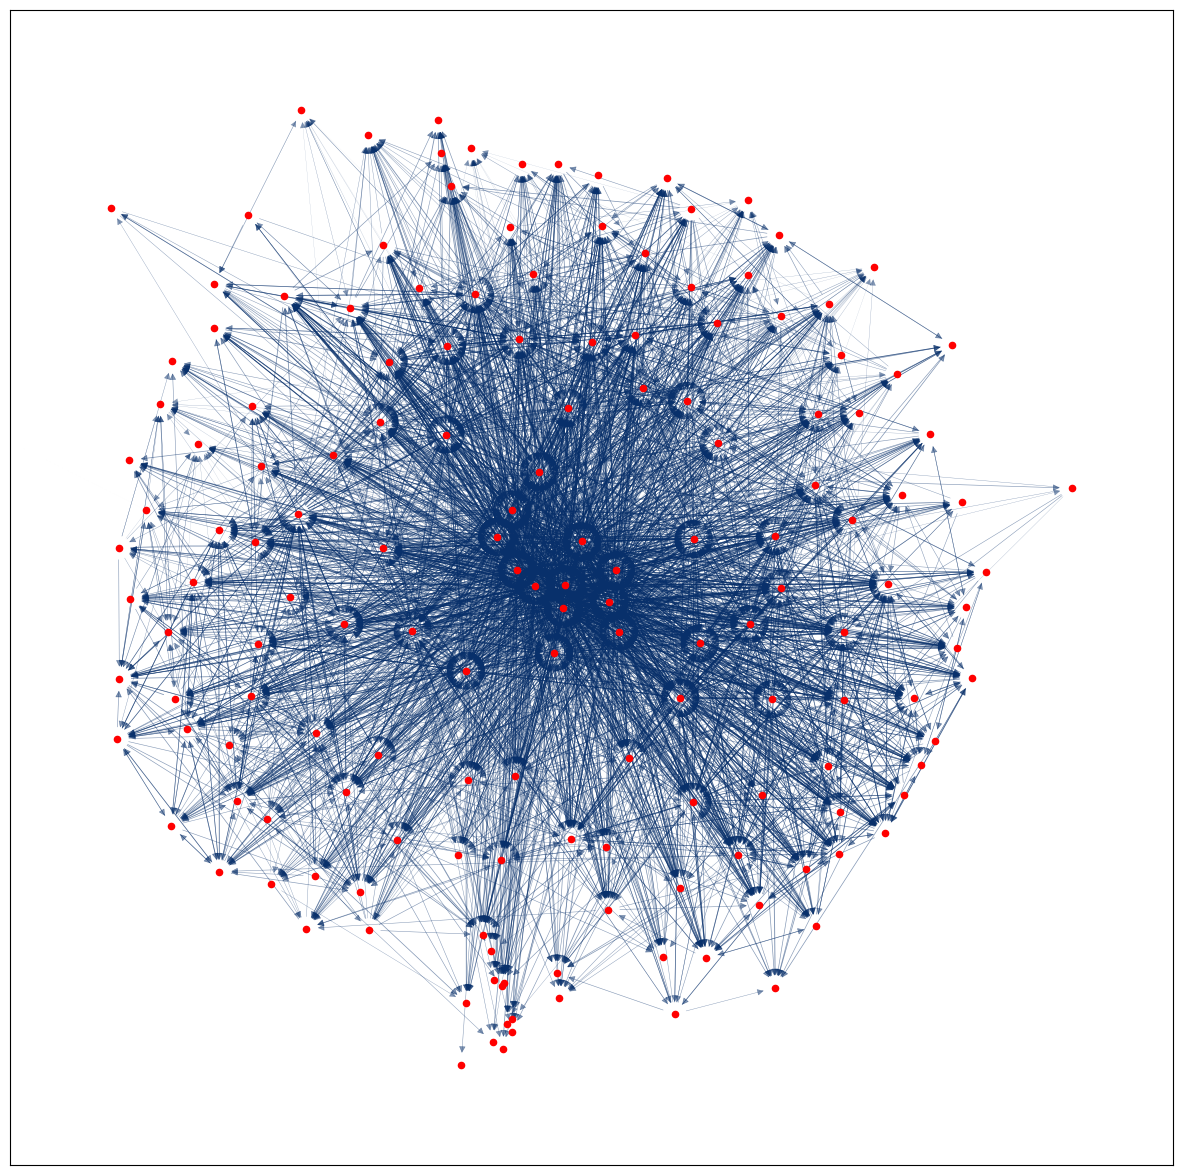

In [5]:
prices = nx.get_edge_attributes(G2005lite, 'price').values()
prices = [math.log(i) for i in list(prices)]
max_price = max(prices)
min_price = min(prices)
norm_prices = [(price - min_price) / (max_price - min_price) for price in prices]

edges = G2005lite.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]

# draw the graph
pos = nx.kamada_kawai_layout(G2005lite)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2005lite, pos, node_size=20, node_color='red')
#nx.draw_networkx_edges(G2005lite, pos, alpha=0.5)
nx.draw_networkx_edges(G2005lite, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)

plt.savefig("network2005.png")
plt.show()

In [6]:
G2005.edges.data('price')

OutEdgeDataView([('ALB', 'ARE', 1240.77), ('ALB', 'ARG', 2169.89), ('ALB', 'AUS', 896.984), ('ALB', 'AUT', 44350.5), ('ALB', 'AZE', 2289.66), ('ALB', 'BEL', 19719.0), ('ALB', 'BGD', 0.769), ('ALB', 'BGR', 72907.4), ('ALB', 'BHR', 21.961), ('ALB', 'BIH', 3329.8), ('ALB', 'BLR', 6742.75), ('ALB', 'BRA', 23056.0), ('ALB', 'BRB', 9.863), ('ALB', 'CAN', 5019.22), ('ALB', 'CHE', 18256.0), ('ALB', 'CHL', 125.588), ('ALB', 'CHN', 168401.0), ('ALB', 'CIV', 0.909), ('ALB', 'CMR', 29.075), ('ALB', 'COL', 2053.34), ('ALB', 'COM', 31.321), ('ALB', 'CRI', 507.844), ('ALB', 'CYP', 4170.59), ('ALB', 'CZE', 17936.4), ('ALB', 'DEU', 132743.0), ('ALB', 'DMA', 18.29), ('ALB', 'DNK', 6183.97), ('ALB', 'DZA', 140.379), ('ALB', 'ECU', 7874.58), ('ALB', 'EGY', 11229.2), ('ALB', 'ESP', 44071.9), ('ALB', 'EST', 189.529), ('ALB', 'ETH', 11.92), ('ALB', 'FIN', 14028.3), ('ALB', 'FRA', 30892.6), ('ALB', 'GAB', 16.573), ('ALB', 'GBR', 21991.6), ('ALB', 'GEO', 8963.8), ('ALB', 'GHA', 49.803), ('ALB', 'GIN', 5.749), 

In [7]:
gdp_df = pd.read_csv('datasets/GDP.csv')
gdp2005 = gdp_df[gdp_df['Year']==2005][['Code', 'GDP (constant 2015 US$)']]

node_in =  pd.DataFrame.from_dict(dict(G2005.in_degree()),orient="index", columns=['Imp Deg']).reset_index()
node_out =  pd.DataFrame.from_dict(dict(G2005.out_degree()),orient="index", columns=['Exp Deg']).reset_index()
df_2005 = pd.merge(node_in, node_out, on='index')
df_2005 = df_2005.sort_values(by='index')
df_2005.reset_index(drop=True, inplace=True)
df_2005['Tot Deg'] = df_2005['Imp Deg'] + df_2005['Exp Deg']
df_2005['Import'] = Tot2005['Imp']
df_2005['Export'] = Tot2005['Exp']
df_2005['Tot Partners'] = [find_neighbors(G2005, i) for i in df_2005['index']]
df_2005['GDP'] = [np.NaN for _ in range(len(df_2005))]
for id in df_2005['index']:
    try:
        df_2005.loc[df_2005['index'] == id, 'GDP'] = gdp2005.loc[gdp2005['Code'] == id, 'GDP (constant 2015 US$)'].iloc[0]
    except:
        continue

df_2005

index  Imp Deg  Exp Deg  Tot Deg        Import        Export  \
0     AGO       85        0       85  0.000000e+00  2.101176e+07   
1     ALB       94      113      207  2.468323e+06  6.358189e+05   
2     ARE      133      142      275  5.998854e+07  7.970136e+07   
3     ARG      135      123      258  2.843278e+07  4.260389e+07   
4     ARM       76       93      169  1.563535e+06  7.869679e+05   
..    ...      ...      ...      ...           ...           ...   
156   VNM      135      138      273  3.166304e+07  3.389133e+07   
157   YEM       83      120      203  4.933262e+06  5.376410e+06   
158   ZAF      136      160      296  5.334689e+07  5.507576e+07   
159   ZMB       90      104      194  2.502708e+06  2.466188e+06   
160   ZWE      107      114      221  1.983931e+06  1.937457e+06   

     Tot Partners           GDP  
0              85  4.873740e+10  
1             126  8.057260e+09  
2             151  2.601922e+11  
3             145  4.352966e+11  
4             105  7.048228e+09  
..            ...           ...  
156           153  1.305492e+11  
157           127  5.099547e+10  
158           160  2.675469e+11  
159           119  1.088771e+10  
160           134  1.351758e+10  

[161 rows x 8 columns]

In [8]:
param = 'Import'

percentile_99 = np.percentile(df_2005[param], 98)
hub_nodi = df_2005[df_2005[param] >= percentile_99]['index'].tolist()
print('Nodes hub 2005: ', hub_nodi)

Nodes hub 2005:  ['CHN', 'DEU', 'GBR', 'USA']


## Density

In [9]:
density = nx.density(G2005)
print('Density 2000: {}'.format(density))

Density 2000: 0.6677406832298136


## Degree

In [10]:
degree = list(dict(G2005.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2005)))

Standard deviation: 71.77843778072834
Mean: 213.67701863354037
Median: 228.0
Min: 23
Max: 300
Assortativity coefficient: -0.22299489791267904


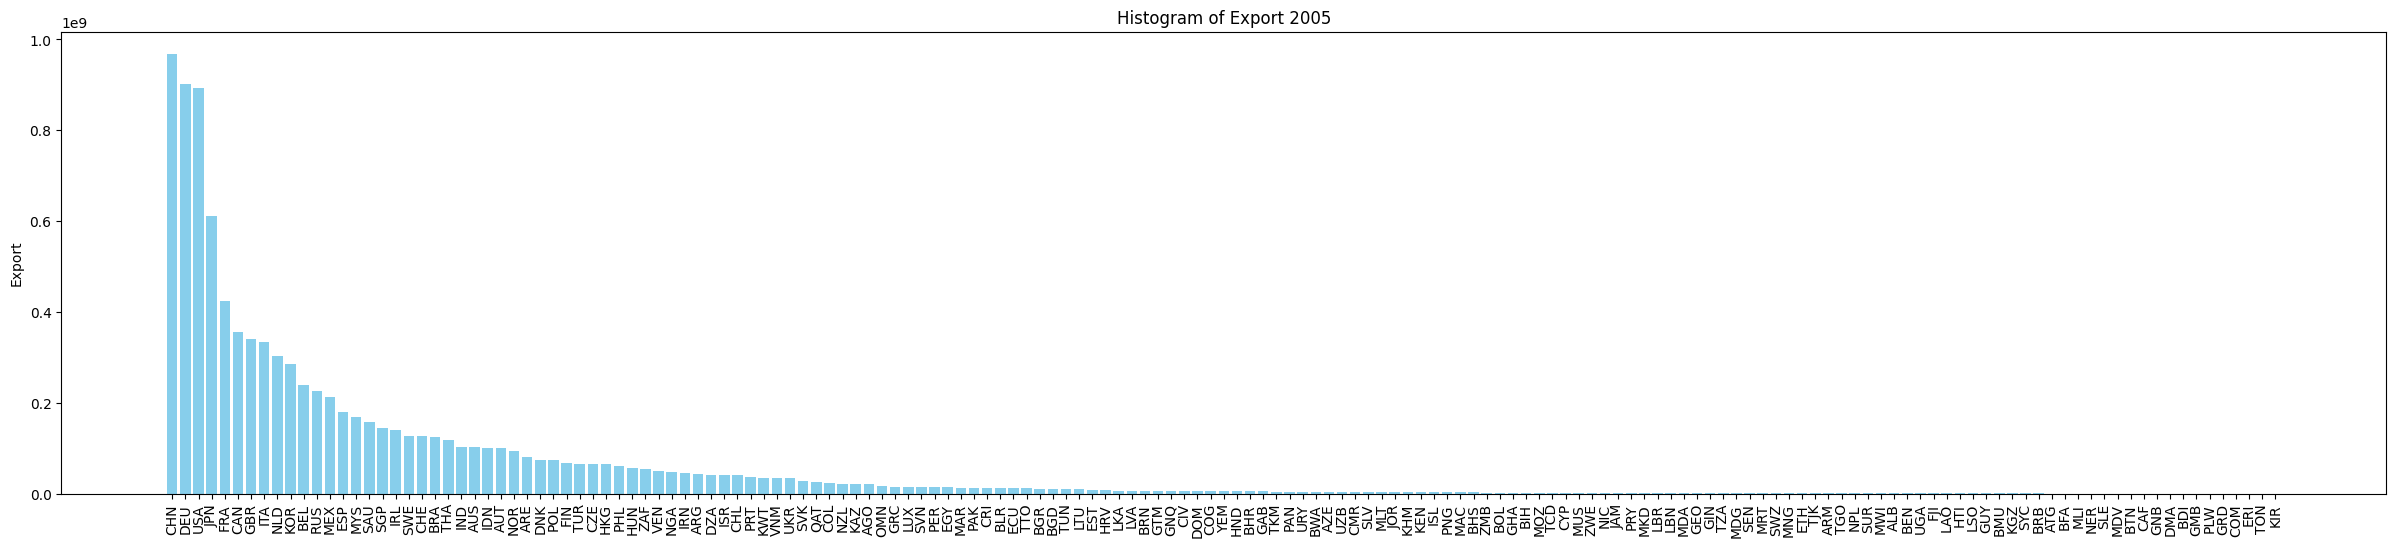

In [11]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2005.sort_values(by=plot, ascending=False)['index'], df_2005.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2005')
plt.xticks(rotation=90)
plt.savefig(plot+"2005.png")
plt.show()


In [12]:
print(list(nx.isolates(G2005)))

[]


In [13]:
clusters = nx.average_clustering(G2005lite) #weight='price'
clusters

0.6826605717949387

In [14]:
local_cluster = nx.clustering(G2005, weight='price')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('USA', 0.003039373865286059),
 ('DEU', 0.0025979414513849952),
 ('CHN', 0.0021884972871977935),
 ('JPN', 0.0017740217303135828),
 ('FRA', 0.001757438297176281),
 ('GBR', 0.0017200414203662855),
 ('ITA', 0.0014943584713762476),
 ('NLD', 0.0012827645604202092),
 ('BEL', 0.0012071212153364215),
 ('KOR', 0.00113138347330557),
 ('ESP', 0.0011095529364853484),
 ('SGP', 0.0010052480584647582),
 ('RUS', 0.0008828717420558746),
 ('CAN', 0.0008700898906424254),
 ('SWE', 0.0007237848330170504),
 ('CHE', 0.0007199528248905413),
 ('SAU', 0.0006829656439234369),
 ('BRA', 0.0006585177976533721),
 ('THA', 0.0006537567982771654),
 ('HKG', 0.0006529972191638266),
 ('IND', 0.0006521268447309462),
 ('MYS', 0.0006500773856413679),
 ('TUR', 0.0006265361350597673),
 ('MEX', 0.0006233574081824875),
 ('AUS', 0.0006052187704645217),
 ('AUT', 0.000595795447954602),
 ('IRL', 0.0005517378509007101),
 ('POL', 0.000543035879643364),
 ('FIN', 0.0005016405471749581),
 ('DNK', 0.0005015379255615513),
 ('IDN', 0.00049

## Centrality

In [15]:
import statistics
deg_centr = nx.degree_centrality(G2005)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 1.335481366459628
median of degree centrality: 1.425
min of degree centrality: ('PLW', 0.14375000000000002)
max of degree centrality: ('DEU', 1.875)
10 most important nodes for Degree Centrality:
('DEU', 1.875)
('GBR', 1.8687500000000001)
('ITA', 1.8687500000000001)
('JPN', 1.8687500000000001)
('USA', 1.8687500000000001)
('MYS', 1.8625)
('CHN', 1.8562500000000002)
('FRA', 1.8562500000000002)
('IND', 1.8562500000000002)
('AUS', 1.85)


## BETWEENNESS

In [16]:
betweenesCentrality = nx.betweenness_centrality(G2005, weight='price')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.022701448298761664
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('NIC', 0.1895440251572327)
('NIC', 0.1895440251572327)
('UGA', 0.16898584905660377)
('ATG', 0.16132075471698112)
('YEM', 0.15169025157232705)
('BRB', 0.14437893081761005)
('BWA', 0.13579009433962264)
('CIV', 0.11595911949685533)
('DOM', 0.11401336477987421)
('CYP', 0.11053459119496854)
('ZWE', 0.10941430817610062)


## Eigenvector

In [17]:
eigen = nx.eigenvector_centrality(G2005, weight='price')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.02883151883210447
max of eigenvector centrality: ('CHN', 0.5098459628520773)
10 most important nodes for Eigenvector Centrality:
('CHN', 0.5098459628520773)
('USA', 0.42691244469972967)
('JPN', 0.36319709208647805)
('CAN', 0.3251826427915546)
('DEU', 0.2943916103739065)
('KOR', 0.19246346028940264)
('MEX', 0.19188998825478254)
('FRA', 0.158027519197231)
('GBR', 0.14570645514031447)
('ITA', 0.12468185261288106)


## Pagerank

In [18]:
pagerank = nx.pagerank(G2005, alpha=0.85, weight='price')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.006211180124223602
max of pagerank: ('USA', 0.08239619556421264)
10 most important nodes for Page Rank:
('USA', 0.08239619556421264)
('DEU', 0.07393779952699016)
('CHN', 0.0710697773416818)
('JPN', 0.053796649618176894)
('FRA', 0.03820157565274238)
('GBR', 0.03134965428446847)
('ITA', 0.029295725663051355)
('KOR', 0.027336378408804946)
('NLD', 0.024874462822552672)
('RUS', 0.02343658973851966)


## Closeness

In [19]:
closeness = nx.closeness_centrality(G2005)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.7234801289723973
10 most important nodes for closeness_centrality:
('CHN', 0.875)
('DEU', 0.875)
('FRA', 0.875)
('GBR', 0.875)
('IND', 0.875)
('ITA', 0.875)
('JPN', 0.875)
('BRA', 0.8687943262411347)
('MYS', 0.8687943262411347)
('SGP', 0.8687943262411347)


# Communities

In [20]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2005,weight='price'))
print(list_community_sets_greedy[0:20])

[frozenset({'BLR', 'LUX', 'IRL', 'MLI', 'BIH', 'DNK', 'NER', 'EGY', 'CHE', 'ISL', 'HUN', 'SEN', 'PRT', 'RUS', 'NOR', 'GIN', 'TGO', 'HRV', 'SYC', 'LTU', 'BMU', 'CZE', 'FIN', 'BEL', 'MKD', 'GHA', 'MLT', 'BDI', 'SWE', 'MAR', 'ITA', 'MRT', 'ALB', 'NLD', 'CYP', 'SVN', 'SLE', 'GMB', 'DZA', 'LBR', 'DEU', 'LBN', 'GRC', 'UKR', 'AUT', 'BGR', 'CMR', 'TUR', 'CIV', 'POL', 'BFA', 'KGZ', 'UZB', 'SVK', 'MDA', 'ESP', 'LVA', 'TKM', 'AZE', 'FRA', 'KAZ', 'EST', 'TJK', 'BEN', 'ARM', 'TUN', 'GBR', 'CAF', 'GEO'}), frozenset({'KOR', 'SWZ', 'THA', 'MDV', 'SGP', 'SAU', 'KIR', 'YEM', 'VNM', 'ZAF', 'ZMB', 'UGA', 'HKG', 'MWI', 'KEN', 'ETH', 'OMN', 'MNG', 'JPN', 'ERI', 'PLW', 'MAC', 'IDN', 'JOR', 'COM', 'GNB', 'MDG', 'NPL', 'COG', 'IND', 'TZA', 'ZWE', 'ARE', 'MOZ', 'QAT', 'BWA', 'LKA', 'TON', 'PNG', 'KWT', 'PAK', 'LAO', 'BGD', 'NZL', 'BRN', 'BHR', 'IRN', 'PHL', 'MYS', 'AUS', 'BTN', 'MUS', 'CHN', 'FJI'}), frozenset({'JAM', 'HTI', 'TCD', 'TTO', 'NGA', 'ISR', 'BRA', 'NIC', 'SUR', 'PER', 'ECU', 'GTM', 'URY', 'GAB', 'ME

In [21]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 69
Community: 1
Number of elems 54
Community: 2
Number of elems 38


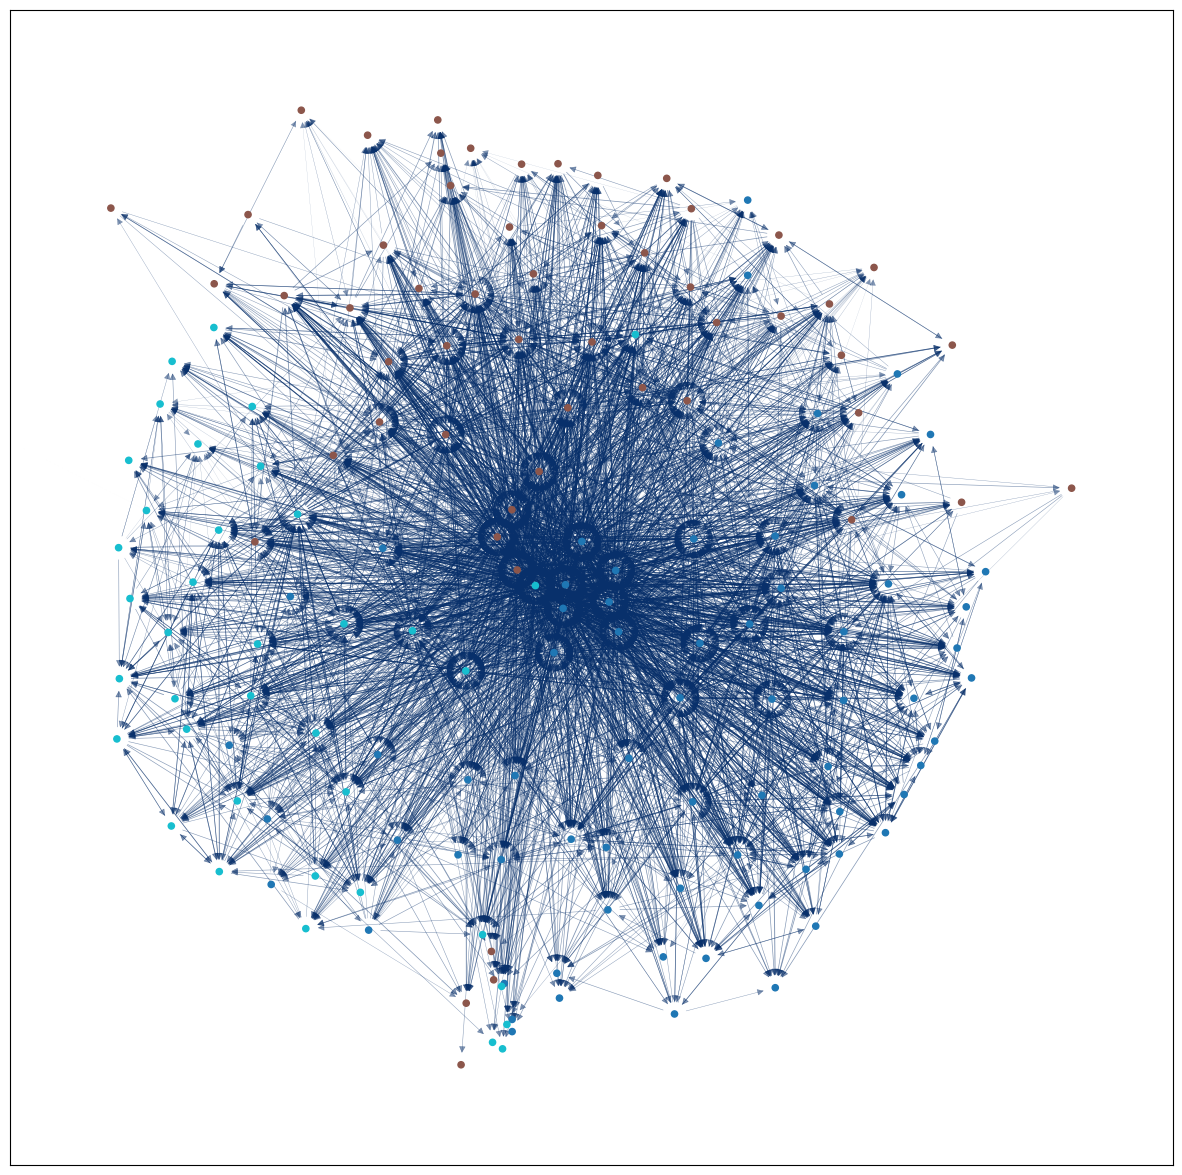

In [22]:
# draw the graph
pos = nx.kamada_kawai_layout(G2005lite)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2005lite, pos, partition_greedy.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2005lite, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)


plt.show()

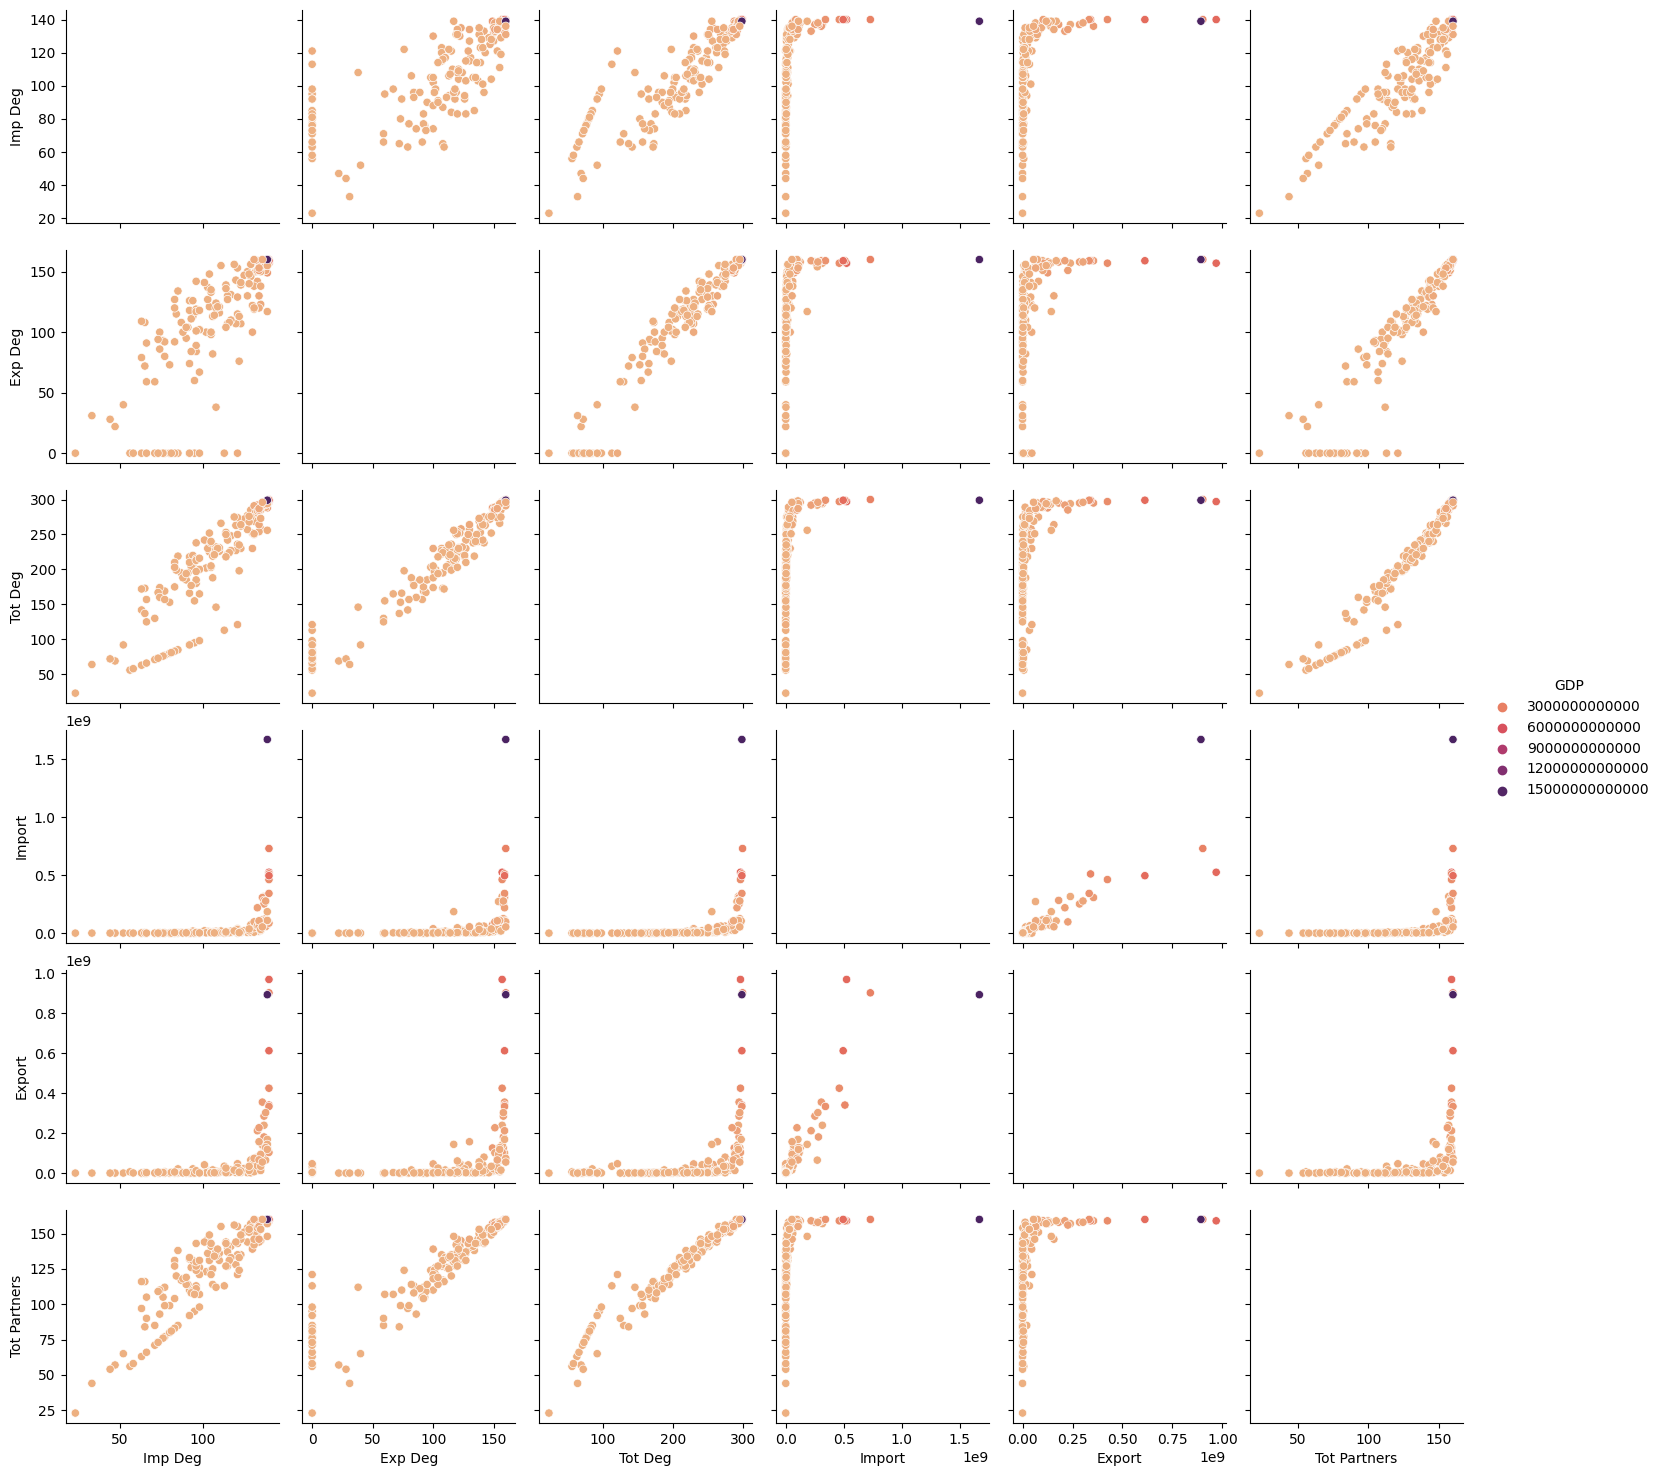

In [23]:
sns.pairplot(df_2005, hue = 'GDP'
             , diag_kind='auto',
             palette='flare'
            )